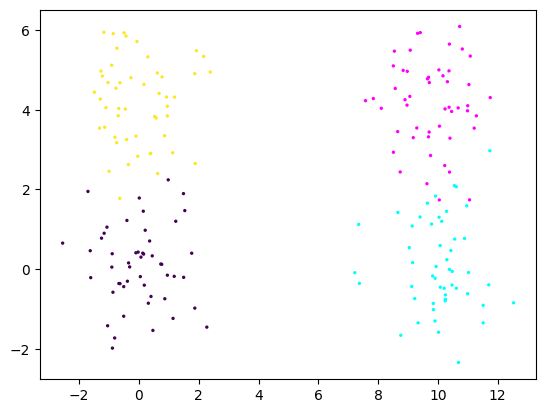

In [99]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

"""Create synthetic dataset and dataloaders for domain adaptation."""
# Create datasets
ns, nt = 100, 100

xs, ys = make_blobs(ns, centers=[[0, 0], [0, 4]], cluster_std=1)
xt, yt = make_blobs(nt, centers=[[10, 0], [10, 4]], cluster_std=1)

plt.scatter(xs[:, 0], xs[:, 1], c=ys, cmap='viridis', s=2)
plt.scatter(xt[:, 0], xt[:, 1], c=yt, cmap='cool', s=2)
plt.show()

In [100]:
import torch
import torch.nn as nn
from typing import List

class Generator(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Feature extractor network."""
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Domain critic network."""
        super().__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)
    
from typing import Optional
import numpy as np
from tqdm.notebook import trange
from torch.utils.data import DataLoader

class WDGRL():
    def __init__(self, input_dim: int=2, generator_hidden_dims: List[int]=[32], critic_hidden_dims: List[int]=[32],
                 gamma: float = 0.1, _lr_generator: float = 1e-2, _lr_critic: float = 1e-2, 
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu', random_seed: Optional[int] = 0):
        if random_seed is not None:
            torch.manual_seed(random_seed)
            np.random.seed(random_seed)
        self.gamma = gamma
        self.device = device
        self.generator = Generator(input_dim, generator_hidden_dims).to(self.device)
        self.critic = Critic(generator_hidden_dims[-1], critic_hidden_dims).to(self.device)
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=_lr_generator)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=_lr_critic)
    
    # Moderate this function to make it capable of dealing with imbalance batch (unequal number of target and source samples)
    def compute_gradient_penalty(self, source_data: torch.Tensor, target_data: torch.Tensor) -> torch.Tensor:
        """Compute gradient penalty."""
        alpha = torch.rand(source_data.size(0), 1).to(self.device)
        interpolates = (alpha * source_data + ((1 - alpha) * target_data)).requires_grad_(True)
        
        # Domain critic outputs
        dc_output = self.critic(interpolates)
        
        # Compute gradients
        gradients = torch.autograd.grad(
            outputs=dc_output,
            inputs=interpolates,
            grad_outputs=torch.ones_like(dc_output).to(self.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        # Compute gradient penalty
        gradients = gradients.view(gradients.size(0), -1)
        return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    def train(self, source_loader: DataLoader, target_loader: DataLoader, num_epochs: int = 100, dc_iter: int = 100) -> List[float]:
        self.generator.train()
        self.critic.train()
        losses = []
        source_critic_scores = []
        target_critic_scores = []
        for epoch in trange(num_epochs, desc='Epoch'):
            loss = 0
            for (source_data, _), (target_data, _) in zip(source_loader, target_loader):
                source_data, target_data = source_data.to(self.device), target_data.to(self.device)

                # Train domain critic
                for _ in range(dc_iter):
                    self.critic_optimizer.zero_grad()
                    
                    with torch.no_grad():
                        source_features = self.generator(source_data)
                        target_features = self.generator(target_data)
                    
                    # Compute empirical Wasserstein distance
                    dc_source = self.critic(source_features)
                    dc_target = self.critic(target_features)
                    wasserstein_distance = dc_source.mean() - dc_target.mean()

                    # Gradient penalty
                    gradient_penalty = self.compute_gradient_penalty(source_features, target_features)

                    # Domain critic loss
                    dc_loss = - wasserstein_distance + self.gamma * gradient_penalty
                    dc_loss.backward()
                    self.critic_optimizer.step()

                # Train feature extractor
                self.generator_optimizer.zero_grad()
                source_features = self.generator(source_data)
                target_features = self.generator(target_data)
                dc_source = self.critic(source_features)
                dc_target = self.critic(target_features)
                wasserstein_distance = dc_source.mean() - dc_target.mean()
                wasserstein_distance.backward()
                self.generator_optimizer.step()
                
                with torch.no_grad():
                    loss += wasserstein_distance.item()
                    
            source_critic_scores.append(self.criticize(source_loader.dataset.tensors[0].to(self.device)))
            target_critic_scores.append(self.criticize(target_loader.dataset.tensors[0].to(self.device)))
            losses.append(loss/len(source_loader))
            print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {wasserstein_distance.item()}')
        return losses, source_critic_scores, target_critic_scores
    
    @torch.no_grad()
    def extract_feature(self, x: torch.Tensor) -> torch.Tensor:
        self.generator.eval()
        self.critic.eval()
        return self.generator(x)
    
    @torch.no_grad()
    def criticize(self, x: torch.Tensor) -> float:
        self.generator.eval()
        self.critic.eval()
        return self.critic(self.generator(x)).mean().item()

In [101]:
# Create a new instance of the WDGRL model (same architecture as before)
model = WDGRL()

# Load the saved checkpoint
checkpoint = torch.load("wdgrl.pth", map_location=model.device, weights_only=True)

# Restore the model weights
model.generator.load_state_dict(checkpoint['generator_state_dict'])
model.critic.load_state_dict(checkpoint['critic_state_dict'])

print("Model loaded successfully!")

Model loaded successfully!


In [102]:
xs = torch.FloatTensor(xs)
ys = torch.LongTensor(ys)
xt = torch.FloatTensor(xt)
yt = torch.LongTensor(yt)

xs_hat = model.extract_feature(xs)
xt_hat = model.extract_feature(xt)
xs_hat.shape, xt_hat.shape

(torch.Size([100, 32]), torch.Size([100, 32]))

In [103]:
print(xt_hat)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [104]:
x_hat = torch.cat([xs_hat, xt_hat], dim=0)
detect_outlier_idx = []
alpha = 1.5
for i in range(x_hat.shape[1]):
    x_hat_i = x_hat[:, i]
    median = x_hat_i.median().item()
    mad = torch.abs(x_hat_i - median).median().item()
    lower = median - alpha * mad
    upper = median + alpha * mad
    for j in range(nt):
        value = xt_hat[j, i].item()
        if value < lower or value > upper and j not in detect_outlier_idx:
            detect_outlier_idx.append(j)

In [105]:
print(yt[detect_outlier_idx].sum().item())

40
